In [2]:
import bs4 as bs
import requests
import yfinance as yf
import datetime

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

plt.rcParams['figure.figsize']= 8,5
fig = plt.figure()

import random
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_t

from gerber_utils import *

<Figure size 432x288 with 0 Axes>

# Demonstration

Visualization of $\,tanh(a(x-c))  tanh(b(y-d))$.

Some characteristics:
- $a$ and $b$ control how steep the transition (gradient) from 1 to -1 is for the x-axis and y-axis, respectively. 
    - It essentially stretches or squahses the whole surface. 
- $c$ and $d$ horizontally translates the surface by $c$ and $d$ units in the x-axis and y-axis, respectively.
- When $a$ and $b$ are small, the surface is smooth. When they are big, the surface becomes more like a step-function.

Some observations:
- As $a$ and $b$ approach infinity, the surface becomes identical to the $m_{ij}(t)$ used in Gerber statistic **where thresholds are set to 0 for all stocks.**
    - Note in this case, the Gerber statistic computed with $\frac{n_c - n_d}{n_c + n_d} = \frac{\sum m_{ij}(t)}{\sum |m_{ij}(t)|}$ is identical to Kendall's Tau.
- As $a$ and $b$ approach 0, transition from -1 to 1 becomes smooth and esssentially becomes a straight line.

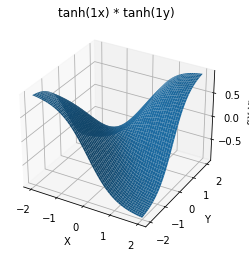

In [3]:
draw_tanhtanh_surface(a=1, b=1, c=0, d=0, rnge=2)
# draw_tanhtanh_surface(a=5, b=5, c=0, d=0, rnge=2)
# draw_tanhtanh_surface(a=5, b=5, c=1, d=0, rnge=2)

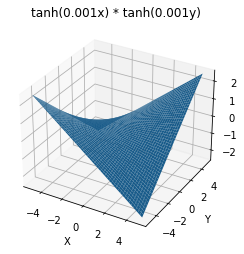

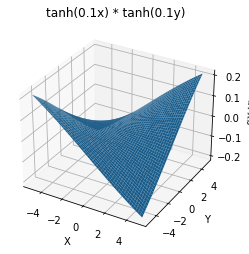

KeyboardInterrupt: 

In [2]:
draw_tanhtanh_surface(a=0.001, b=0.001, c=0, d=0)
draw_tanhtanh_surface(a=0.1, b=0.1, c=0, d=0)
draw_tanhtanh_surface(a=0.5, b=0.5, c=0, d=0)
draw_tanhtanh_surface(a=1, b=1, c=0, d=0)
draw_tanhtanh_surface(a=2, b=2, c=0, d=0)
draw_tanhtanh_surface(a=10, b=10, c=0, d=0)
draw_tanhtanh_surface(a=1000000, b=1000000, c=0, d=0)

# get S&P 500 data

In [5]:
df_close, df_returns = read_returns_snp_data()

# Simulation experiment

### Steps

Want to check if the correlation matrix is always PSD.

- Fix a = b = some number. Fix dof=3 for t-distribution.
- Fix d (number of stocks).
- Randomly pick $d$ stocks from 2022 S&P500 log returns data.
- Compute sample correlation matrix to use as the 'true correlation matrix'.
- Using the true correlation matrix, generate 1000 **(t=1,...,1000)** **normal and t** random variables.
    - 1000 d-dimensional normal observations are generated first. 1000 d-dimensional t observations are generated by generating 1000 gamma(dof/2, 2/dof) variables and doing normal observation / sqrt(gamma).
    - $\chi^2 \sim \Gamma(\alpha, \beta) \sim \frac{\beta}{2}\Gamma (\alpha, 2) \sim \frac{\beta}{2} \chi^2 (2\alpha) = \frac{1}{df} \chi^2 (df)$ when $\alpha=\frac{df}{2}$ and $\beta=\frac{2}{df}$.
- Compute Gerber correlation matrix with each entry $\frac{\sum m_{ij}(t)}{\sum |m_{ij}(t)|}$ for both normal ($G$) and t observations ($G_t$).
- Check if matrices are PSD.
- Repeat 1000 times. ($d$ stocks are randomly chosen again.)

In [6]:
random.seed(1)
np.random.seed(seed=1)

dof = 3
a = 0.2
b = 0.2
d = 20 # number of stocks


nobs=300

corr_dict = {}
psd_dict = {}
eigenv_dict = {}
weights_dict = {} # list of m_ij(t) values for each i,j
obs_dict = {}
t_obs_dict = {}
true_cov_dict = {}
true_corr_dict = {}
stock_indices_dict = {}



for sample_num in range(1, 101):
    if sample_num % 10 == 0: print(f'{sample_num}-th repeat')
        
    weights_dict[sample_num] = {}
    weights_dict[sample_num]['normal'] = {}
    weights_dict[sample_num]['t'] = {} 
    
    corr_dict[sample_num] = {}
    corr_dict[sample_num]['normal'] = {}
    corr_dict[sample_num]['t'] = {} 
    
    # simulation covariance settings
    stock_indices = [random.randrange(0, df_close.shape[1]) for _ in range(d)]
    # if duplicate stocks were chosen, re-pick
    while pd.DataFrame(stock_indices).drop_duplicates().shape[0] < len(stock_indices):
        stock_indices = [random.randrange(0, df_close.shape[1]) for _ in range(d)]
    stock_indices_dict[sample_num] = stock_indices
    df_corr = pd.DataFrame(df_returns.iloc[:, stock_indices].corr())
    true_corr_dict[sample_num] = df_corr
    
    # simulate 300 observations for d stocks
    obs = pd.DataFrame(np.random.multivariate_normal(np.zeros(d), df_corr, nobs))
    obs_dict[sample_num] = obs
    # generate corresponding t-observations (https://stats.stackexchange.com/questions/384066/understanding-this-expression-of-the-multivariate-t-distribution)
    # (https://stats.stackexchange.com/questions/52906/student-t-as-mixture-of-gaussian)
    g = np.random.gamma(dof/2, 2/dof, nobs) # gamma variable
    t_obs = obs/np.sqrt(g[:,None])
    t_obs_dict[sample_num] = t_obs
    
    # initialize empty M sum and M abs sum matrices
    M_sum = np.zeros(d*d).reshape(d,d) # matrix consisting of numerator entries in (eq 3 in gerber 2021)
    M_abs_sum = np.zeros(d*d).reshape(d,d) # matrix consisting of denominator entries in (eq 3 in gerber 2021)
        # for t distribution observations too
    M_sum_t = np.zeros(d*d).reshape(d,d) 
    M_abs_sum_t = np.zeros(d*d).reshape(d,d) 
    
    # fill them in
    triu_indices = np.triu_indices(d)
    for i,j in zip(triu_indices[0], triu_indices[1]):

        # create M_sum and M_abs_sum matrices for upper triangular indicies
        weights_dict[sample_num]['normal'][i,j] = tanhtanh_two_series(obs.iloc[:,[i,j]], a=a, b=b).values
        M_sum[i,j] = weights_dict[sample_num]['normal'][i,j].sum()
        M_abs_sum[i,j] = np.abs(weights_dict[sample_num]['normal'][i,j]).sum()
            # do same for t observations
        weights_dict[sample_num]['t'][i,j] = tanhtanh_two_series(t_obs.iloc[:,[i,j]], a=a, b=b).values
        M_sum_t[i,j] = weights_dict[sample_num]['t'][i,j].sum()
        M_abs_sum_t[i,j] = np.abs(weights_dict[sample_num]['t'][i,j]).sum()
            
        # fill in lower triangular parts by looking at symmetric entries
        M_sum = fill_in_zero_in_symmetric_matrix(M_sum)
        M_abs_sum = fill_in_zero_in_symmetric_matrix(M_abs_sum)
            # do same for t
        M_sum_t = fill_in_zero_in_symmetric_matrix(M_sum_t)
        M_abs_sum_t = fill_in_zero_in_symmetric_matrix(M_abs_sum_t)
        
    # create gerber corr (eq 3 in 2021 paper) matrix. (they say sometimes this is not PSD)
    G = M_sum / M_abs_sum
    G_t = M_sum_t / M_abs_sum_t
    
#     eigenv = np.linalg.eigvals(G)
    is_psd = is_pos_semi_def(G) and is_pos_semi_def(G_t)
    if not is_psd:
        print(sample_num, G, G_t)
        error = {'obs':obs, 'corr_mat':G}#, 'eigenv':eigenv}
        break
    
    corr_dict[sample_num]['normal'] = pd.DataFrame(G)
    corr_dict[sample_num]['t'] = pd.DataFrame(G_t)
    psd_dict[sample_num] = is_psd
#     eigenv_dict[sample_num] = eigenv
    

1 [[1.         0.72302753 0.52458024 0.68582205 0.5048472  0.73678816
  0.69801044 0.29980414 0.54038461 0.69749287 0.62948696 0.66772189
  0.80847663 0.83392349 0.76055083 0.74189038 0.75633681 0.80046109
  0.76689241 0.73543813]
 [0.72302753 1.         0.6778899  0.7475672  0.66056537 0.82710097
  0.62556831 0.42098363 0.32446258 0.77985486 0.46242987 0.81994079
  0.65534922 0.86247098 0.84437566 0.66420527 0.74523906 0.75801856
  0.49941248 0.67051178]
 [0.52458024 0.6778899  1.         0.80346348 0.95714068 0.85545556
  0.49414894 0.42967241 0.48063223 0.73953591 0.61081452 0.80888952
  0.79474759 0.75034453 0.58161397 0.43386178 0.74916452 0.57564597
  0.56589875 0.77717037]
 [0.68582205 0.7475672  0.80346348 1.         0.7852462  0.81558318
  0.6021467  0.36346229 0.50688485 0.79166455 0.59297822 0.81335338
  0.81019497 0.84287347 0.74786207 0.62213805 0.84324487 0.77800189
  0.65871157 0.76243804]
 [0.5048472  0.66056537 0.95714068 0.7852462  1.         0.88831081
  0.47772374 0